# Visualizing MNIST database

This example creates a visualization of the MNIST images (hand written digits) using `MLDatasets.jl` to retrieve it.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto, e.g., start the jupyter 

```bash
JULIA_NUM_THREADS=auto jupyter-lab .
```

_june 1st, 2023: working with `SimilaritySearch` v0.10, also it now uses `Makie` insted of `Plots`_

In [1]:
using Pkg
Pkg.activate(".")
if !isfile("Manifest.toml")
    Pkg.add([
        PackageSpec(name="SimilaritySearch", version="0.10"),
        PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
        PackageSpec(name="MLDatasets"),
        PackageSpec(name="CairoMakie"),
        PackageSpec(name="ColorSchemes"),
        PackageSpec(name="Colors"),
        PackageSpec(name="HypertextLiteral"),
    ])
end

using SimilaritySearch, SimSearchManifoldLearning, CairoMakie, ColorSchemes, Colors
using LinearAlgebra, MLDatasets, HypertextLiteral
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/MNIST`
[ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
[ Info: Precompiling StatsFunsInverseFunctionsExt [da3fed98-1718-55bb-8128-3e4a2e454b06]


# Creating the index

In [2]:
function load_mnist()
    data = MNIST(split=:train)
    T, y = data.features, data.targets
    n = size(T, 3)
    MatrixDatabase(Matrix{Float32}(reshape(T, (28*28, n)))), y
end

function create_index(db)
	dist = SqL2Distance()
    index = SearchGraph(; dist, db, verbose=false)
    callbacks = SearchGraphCallbacks(MinRecall(0.9))
    index!(index; callbacks, neighborhood=Neighborhood(logbase=1.5))
    optimize!(index, MinRecall(0.9))
	index
end


create_index (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [3]:
@time db, y = load_mnist()
@time index = create_index(db);

  1.614203 seconds (778.20 k allocations: 451.459 MiB, 4.52% gc time, 31.97% compilation time)
  6.431457 seconds (5.87 M allocations: 388.289 MiB, 4.36% gc time, 79.52% compilation time)


In [4]:
function search_and_display(index, q, res)
	res = reuse!(res)
    @time search(index, q, res)
	qinverted = 1 .- reshape(q, (28, 28))' # distinguishability
	h = hcat(qinverted, [reshape(index[id_], (28, 28))' for id_ in IdView(res)]...)
	
    Gray.(h)
end


search_and_display (generic function with 1 method)

In [5]:

res = KnnResult(10)
for i in 1:7
    for qid in rand(1:length(index))
        display(@htl "<h2> searching for id $qid </h2>")
        display(search_and_display(index, index[qid], res))
    end
end
    


<h2> searching for id 3193 </h2>

  0.000174 seconds (2 allocations: 32 bytes)


<h2> searching for id 38117 </h2>

  0.000203 seconds (2 allocations: 32 bytes)


<h2> searching for id 1876 </h2>

  0.000226 seconds (2 allocations: 32 bytes)


<h2> searching for id 34771 </h2>

  0.000168 seconds (2 allocations: 32 bytes)


<h2> searching for id 3124 </h2>

  0.000133 seconds (2 allocations: 32 bytes)


<h2> searching for id 33702 </h2>

  0.000153 seconds (2 allocations: 32 bytes)


<h2> searching for id 28202 </h2>

  0.000120 seconds (2 allocations: 32 bytes)


# Visualization

## Functions to create low dimensional projections

In [6]:

function umap_embeddings(index, db; k=15, n_epochs=50, neg_sample_rate=3, tol=1e4, layout=SpectralLayout())
    #layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    #layout = SpectralLayout() ## the results are much better with Spectral layout
    @time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol, min_dist=0.1) 
    #@time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    #jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
    if length(index) == length(db)
        e2 = predict(U2)
        #e3 = predict(U3)
    else
        @time e2 = clamp.(predict(U2, db), -10f0, 10f0)
        #@time e3 = clamp.(predict(U3, db), -10f0, 10f0)
    end
    #(; e2, e3)
    e2
end

umap_embeddings (generic function with 1 method)

UMAP projection can take a while, even on multithreading systems. More even because this example uses SpectralLayout since the number of elements allow it. Note that we are creating 2d and 3d projections

In [7]:
@time uindex = create_index(rand(db, 8000))
@time e2 = umap_embeddings(uindex, db);

  2.096942 seconds (2.15 M allocations: 145.103 MiB, 2.25% gc time, 86.51% compilation time)
  0.021508 seconds (8.13 k allocations: 1.048 MiB)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding


  3.148426 seconds (2.44 M allocations: 1.128 GiB, 2.61% gc time, 78.94% compilation time)


*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.143953336
- embedding init: 2.418735019
- embedding opt: 0.009819831



  1.709013 seconds (428.43 k allocations: 54.980 MiB, 2.62% gc time, 19.28% compilation time)
 14.823023 seconds (16.42 M allocations: 2.062 GiB, 6.31% gc time, 86.22% compilation time)


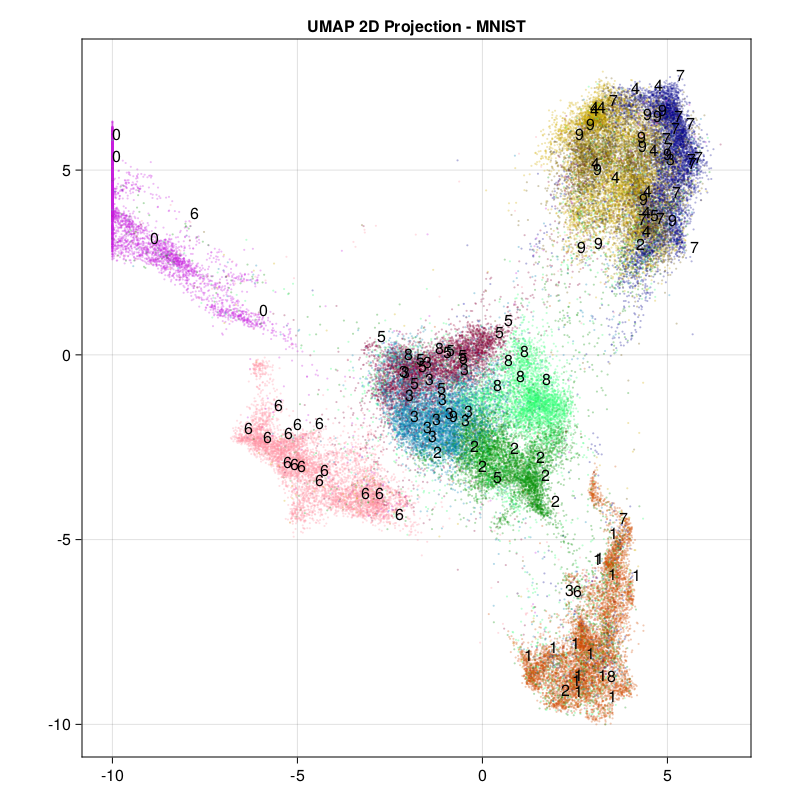

In [8]:
function plot_umap(e2, y)
    cols = distinguishable_colors(10, [RGB(1,1,1), RGB(0,0,0)], dropseed=true)
    C = map(col -> RGBAf(red(col), green(col), blue(col), 0.3), cols)
    C = map(i -> C[i+1], y)
    X = @view e2[1, :]
    Y = @view e2[2, :]
    f = Figure(resolution = (800, 800))
    ax = Axis(f[1,1], title = "UMAP 2D Projection - MNIST", aspect = DataAspect())
    scatter!(ax, X, Y, color=C, markersize=3)
    L = rand(1:length(y), 120)
    text!(ax, X[L], Y[L], text=string.(y[L]), size=7)
    f
end

plot_umap(e2, y)

# Final notes

This example shows how to index and visualize the MNIST dataset using UMAP low dimensional projections. Low dimensional projections are made with `SimSearchManifoldLearning`, note that `SimilaritySearch` is also used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [9]:
Pkg.status()

Status `~/Research/SimilaritySearchDemos/MNIST/Project.toml`
  [13f3f980] CairoMakie v0.10.5
  [35d6a980] ColorSchemes v3.21.0
  [5ae59095] Colors v0.12.10
  [ac1192a8] HypertextLiteral v0.9.4
  [eb30cadb] MLDatasets v0.7.9
  [ca7ab67e] SimSearchManifoldLearning v0.2.8
  [053f045d] SimilaritySearch v0.10.8
